## Aflevering 2

In [1]:
import os
import pandas as pd
file_PE = os.path.join(os.getcwd(),'Elspotprices2nd.csv')
df_prices = pd.read_csv(file_PE)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import Markdown as md
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from math import sqrt
import warnings
import numpy as np

warnings.filterwarnings("ignore")

#### Task 1

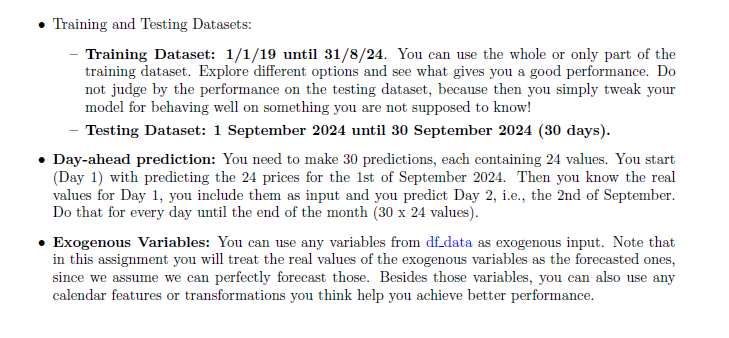

#### Task 1

Antager at vi skal starte med at lave ACF og PACF for at finde ud af hvordan vi fitter modellerne

In [3]:
# Define training and testing periods
train_start = '2023-01-01'
train_end = '2023-08-31'
test_start = '2023-09-01'
test_end = '2023-09-30'


# Split the data from Elspotprices2nd
train_set_E = df_prices[(df_prices['HourUTC'] >= train_start) & (df_prices['HourUTC'] <= train_end)]
test_set_E = df_prices[(df_prices['HourUTC'] >= test_start) & (df_prices['HourUTC'] <= test_end)]

# Split the data from ProdConData
train_set_P = df_data[(df_prices['HourUTC'] >= train_start) & (df_data['HourUTC'] <= train_end)]
test_set_P = df_data[(df_prices['HourUTC'] >= test_start) & (df_data['HourUTC'] <= test_end)]
n = len(train_set_E['SpotPriceDKK'])
N = len(df_prices['SpotPriceDKK'])
print(train_set_E)

                  HourUTC  SpotPriceDKK
35064 2023-01-01 00:00:00     10.260000
35065 2023-01-01 01:00:00      0.670000
35066 2023-01-01 02:00:00      0.590000
35067 2023-01-01 03:00:00      0.370000
35068 2023-01-01 04:00:00      0.590000
...                   ...           ...
40868 2023-08-30 20:00:00    890.580017
40869 2023-08-30 21:00:00    757.169983
40870 2023-08-30 22:00:00    717.840027
40871 2023-08-30 23:00:00    683.919983
40872 2023-08-31 00:00:00    681.469971

[5809 rows x 2 columns]


Laver ACF og PACF på training data

#### Daily

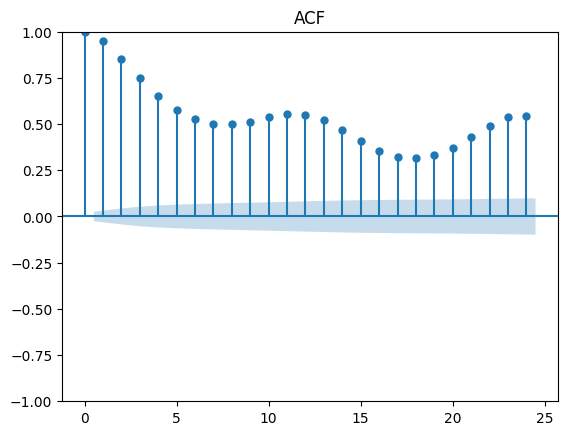

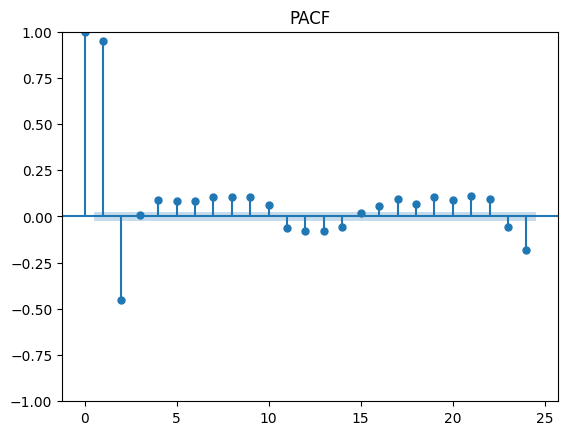

In [4]:
# Check ACF plot
pm.plot_acf(train_set_E['SpotPriceDKK'], lags=24, title = "ACF", alpha = 0.05);
# Check the PACF plot
pm.plot_pacf(train_set_E['SpotPriceDKK'], method='ywm', lags=24, title = "PACF", alpha = 0.05);


#### Weekly

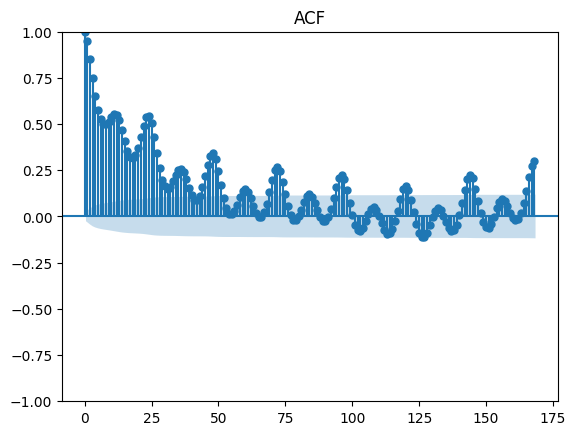

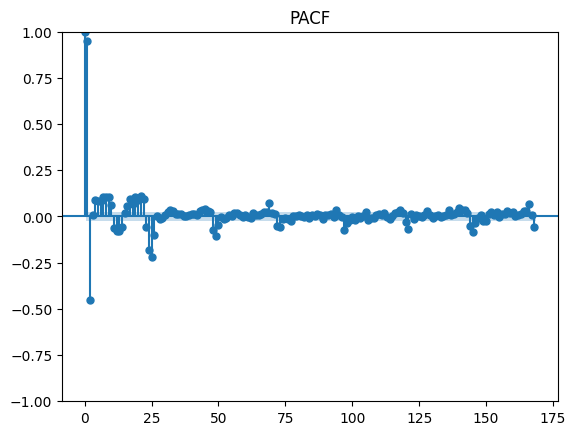

In [5]:
# Check ACF plot
pm.plot_acf(train_set_E['SpotPriceDKK'], lags=168, title = "ACF", alpha = 0.05);
# Check the PACF plot
pm.plot_pacf(train_set_E['SpotPriceDKK'], method='ywm', lags=168, title = "PACF", alpha = 0.05);


## Task 1

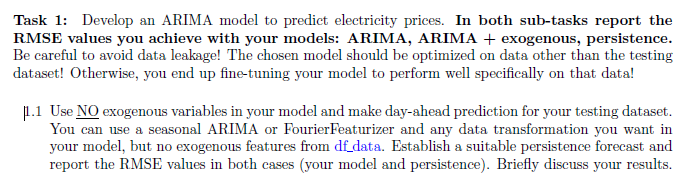

### Differentiere for at forsøge at lave et stationært dataset

Text(0, 0.5, 'x')

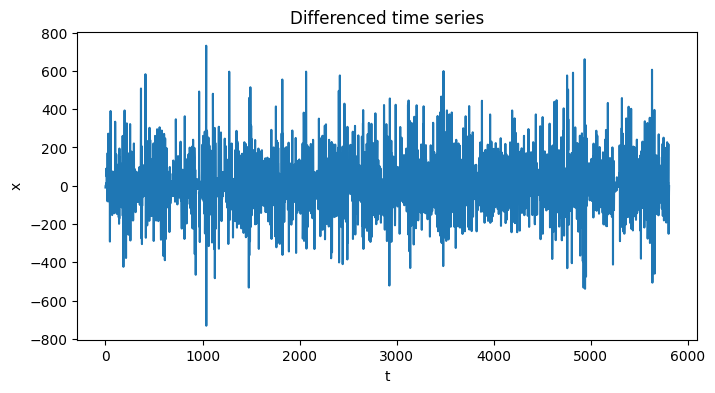

In [6]:
# Calculate the first difference

train_set_E['Diff'] = train_set_E['SpotPriceDKK'].diff()
diff_data = np.diff(train_set_E['SpotPriceDKK'])

# Plot the result
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Differenced time series")
plt.plot(range(0,n-1), diff_data)
plt.xlabel("t")
plt.ylabel("x")

##### Diff

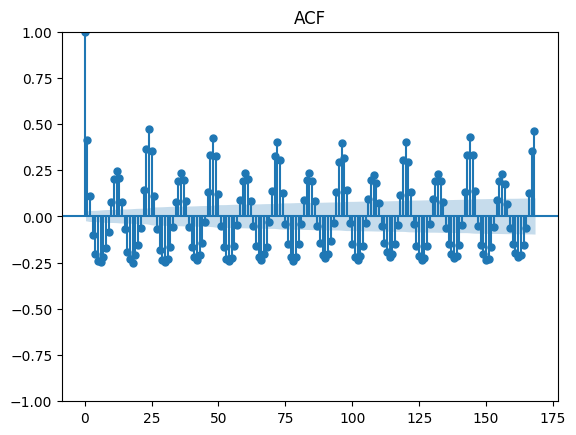

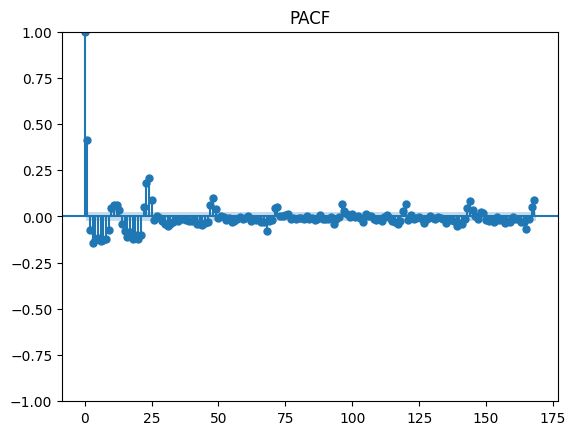

In [7]:
# Check ACF plot
pm.plot_acf(diff_data, lags=168, title = "ACF", alpha = 0.05);
# Check the PACF plot
pm.plot_pacf(diff_data, method='ywm', lags=168, title = "PACF", alpha = 0.05);


In [8]:
diff_data_diff = np.diff(diff_data)

## Finder ud af hvilken Arima model som er smart

#### Auto modeller

In [9]:
model = pm.auto_arima(train_set_E['SpotPriceDKK'], trace = True, seasonal = False, stepwise=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=69924.135, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71490.028, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70396.886, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=70505.536, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71488.034, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=70285.758, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=70182.316, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=69892.826, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=69931.472, Time=0.47 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=69915.767, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=69852.096, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=70325.200, Time=0.53 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=69868.978, Time=0.65 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=69855.364, Time=0.65 sec
 ARIMA(2,1,4)(0,0,0

In [10]:
model1 = pm.auto_arima(train_set_E['SpotPriceDKK'], trace = True, seasonal = True, stepwise=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=69924.135, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71490.028, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70396.886, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=70505.536, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71488.034, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=70285.758, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=70182.316, Time=0.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=69892.826, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=69931.472, Time=0.47 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=69915.767, Time=0.63 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=69852.096, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=70325.200, Time=0.54 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=69868.978, Time=0.64 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=69855.364, Time=0.68 sec
 ARIMA(2,1,4)(0,0,0

In [11]:
model2 = pm.auto_arima(diff_data, trace = True, seasonal = False, stepwise=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=69959.166, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=71488.034, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=70394.890, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=70503.540, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=70280.216, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=70180.817, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=69892.614, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=69888.997, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=70249.646, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=69859.990, Time=0.37 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=70158.752, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=69857.337, Time=0.45 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=70077.933, Time=0.15 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=69919.661, Time=0.46 sec
 ARIMA(4,0,2)(0,0,0

In [12]:
model2 = pm.auto_arima(diff_data, 
                       trace = True, 
                       seasonal = True, 
                       stepwise=True, 
                       maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=69924.216, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=71490.028, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=70396.888, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=70505.537, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=71488.034, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=70285.757, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=70181.936, Time=0.35 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=69892.837, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=69931.476, Time=0.47 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=69915.768, Time=0.52 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=69852.098, Time=0.52 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=70325.202, Time=0.45 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=69868.980, Time=0.51 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=69855.367, Time=0.64 sec
 ARIMA(2,0,4)(0,0,0

ARIMA(1,0,2) på diff data er det bedste. Dette kan også ses ved 

#### Task 1,1

#### Laver en diagnostics

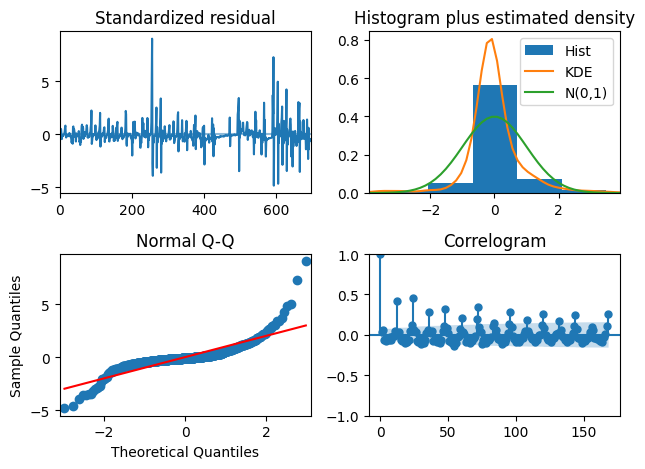

Summary of differentiated data
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  697
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -4683.063
Date:                Mon, 31 Mar 2025   AIC                           9376.126
Time:                        18:44:59   BIC                           9398.853
Sample:                             0   HQIC                          9384.914
                                - 697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1172      0.499     -0.235      0.814      -1.096       0.862
ar.L1          0.7090      0.021     33.184      0.000       0.667       0.751
ma.L1         -0.5285

In [13]:
model = pm.arima.ARIMA(order=(1, 1, 2))
model.fit(test_set_E['SpotPriceDKK'])
model_diagnostics = model.plot_diagnostics(lags=168, fig=plt.figure())
plt.tight_layout()
plt.show()
print("Summary of differentiated data")
print(model.summary())

Kigger på Ljung-Box som skal være lille, en prob som er høj og AIC og BIC som er lave

##### Her laver jeg funktionen i en uge uden at putte den i en funktion

In [14]:
frc_values = []
train = train_set_E['SpotPriceDKK'].values[1:168]
test = test_set_E['SpotPriceDKK'].values[1:168]

model =pm.arima.ARIMA(order=(1, 1, 2)) 
model.fit(train)

 
for k in range(len(test)):
    m = model.predict(1)[0]
    frc_values.append(m)
    model.update(test[k])

rmse_AR = sqrt(mean_squared_error(test, frc_values))
MAE_AR = mean_absolute_error(test, frc_values)

print("The model gives an RMSE of", float("{:.3f}".format(rmse_AR)))
print("The model gives an MAE of", float("{:.3f}".format(MAE_AR)))

The model gives an RMSE of 117.531
The model gives an MAE of 75.713


In [15]:
train = train_set_E['SpotPriceDKK'].values
test = test_set_E['SpotPriceDKK'].values
data = df_prices['SpotPriceDKK'].values

##### Laver forecaster funktion

In [16]:
def Forecaster(data):
    
    # Split the dataset into training and testing dataset
    frc_values = []
    model =pm.arima.ARIMA(order=(1, 1, 2)) 
    model.fit(train)
    
    # Perform the forecasts
    for k in range(len(test)):
        m = model.predict(1)[0]
        frc_values.append(m)
        model.update(test[k])

    # Calculate error metrics
    residuals = result = [a - b for a, b in zip(test, frc_values)]
    rmse_AR = sqrt(mean_squared_error(test, frc_values))
    MAE_AR = mean_absolute_error(test, frc_values)
    print("The model gives an RMSE of", float("{:.3f}".format(rmse_AR)))
    print("The model gives an MAE of", float("{:.3f}".format(MAE_AR)))

    # Plot the forecasts
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train)), train, label="Historical data")
    plt.plot(range(len(train), len(train) + len(test)), test, label="Real values")
    plt.plot(range(len(train), len(train) + len(test)), frc_values, label="Forecasted values")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.xlim(45000, len(data))
    # plt.ylim(45000, len(data))
    plt.title("Forecasting Performance")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Plot the forecasts
    # plt.figure(figsize=(8,4), dpi = 100)
    # plt.plot(range(0,len(train)), train)
    # plt.plot(range(len(train)+1,len(data)+1), test)
    # plt.plot(range(len(train)+1,len(data)+1), frc_values)
    # plt.xlim([len(train)-50,len(data)])
    # plt.xlabel("t")
    # plt.ylabel("x")
    # plt.title("Forecasting performance")
    # plt.legend(["Historical data", "Real values", "Forecasted values"])
    # plt.tight_layout()
    # plt.show()
    # Plot the residuals (forecasting errors)
    # plt.figure()
    # plt.plot(range(0,len(residuals)), residuals)
    # plt.title("Forecasting errors")
    # plt.xlabel("t")
    # plt.ylabel("residual")
    # plt.tight_layout()
    # plt.show()    

The model gives an RMSE of 206.807
The model gives an MAE of 109.528


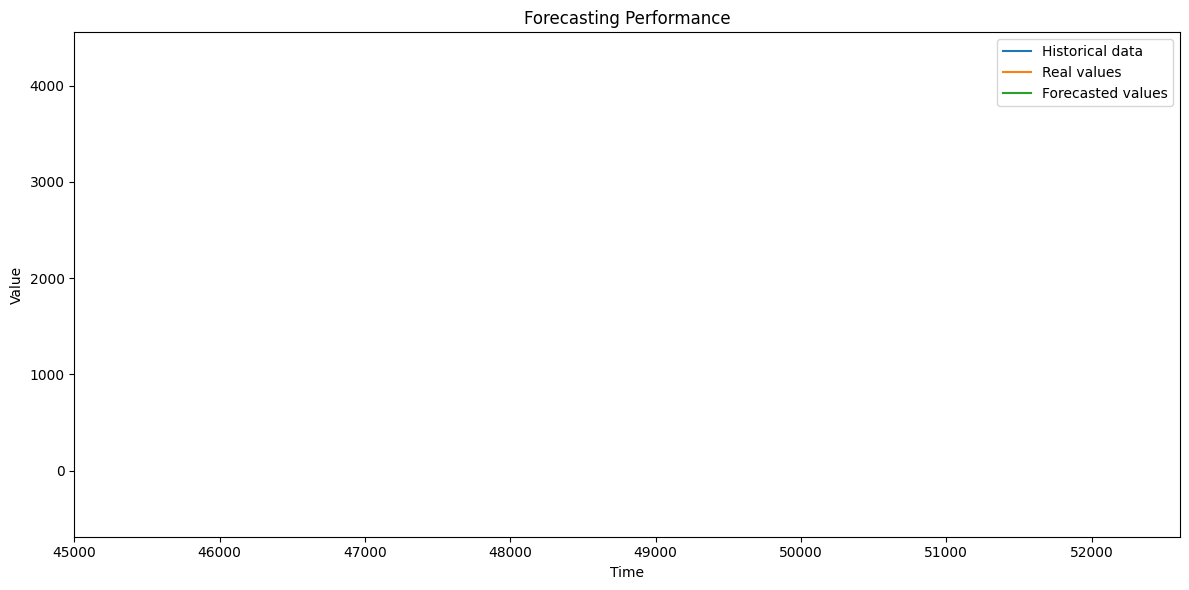

In [19]:
Forecaster(data)

#### Et forsøg på Task 1.2 med exogenous variables

In [28]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Merge dataframes to find top 3 exogenous variables
merged_df = pd.merge(elspot_df, prodcon_df, on="HourUTC")
correlation_df = merged_df.dropna()

# Find top 3 variables most correlated with SpotPriceDKK
correlations = correlation_df.corr(numeric_only=True)["SpotPriceDKK"].sort_values(key=abs, ascending=False)
top_exog_vars = correlations.drop("SpotPriceDKK").head(3).index.tolist()
print("Top 3 exogenous variables:", top_exog_vars)

# Redefine train/test using same logic as in the notebook
train_start = '2023-01-01'
train_end = '2023-08-31'
test_start = '2023-09-01'
test_end = '2023-09-30'

# Extract data
train_set_E = elspot_df[(elspot_df['HourUTC'] >= train_start) & (elspot_df['HourUTC'] <= train_end)]
test_set_E = elspot_df[(elspot_df['HourUTC'] >= test_start) & (elspot_df['HourUTC'] <= test_end)]

train_set_P = prodcon_df[(prodcon_df['HourUTC'] >= train_start) & (prodcon_df['HourUTC'] <= train_end)]
test_set_P = prodcon_df[(prodcon_df['HourUTC'] >= test_start) & (prodcon_df['HourUTC'] <= test_end)]

# Merge on HourUTC
train_df = pd.merge(train_set_E, train_set_P, on="HourUTC").set_index("HourUTC")
test_df = pd.merge(test_set_E, test_set_P, on="HourUTC").set_index("HourUTC")

# Only use first 24 hours of test set (1 day)
test_df_reduced = test_df.iloc[:24]

# Define training variables
y_train = train_df["SpotPriceDKK"]
X_train = train_df[top_exog_vars]

# Fit SARIMAX without seasonal component for speed
model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecast for first 24 hours of September
X_forecast = test_df_reduced[top_exog_vars]
y_forecast = model_fit.forecast(steps=24, exog=X_forecast)

# True and persistence
y_true = test_df_reduced["SpotPriceDKK"]
persistence_values = train_df["SpotPriceDKK"].iloc[-24:]

# RMSE
arima_rmse = np.sqrt(mean_squared_error(y_true, y_forecast))
persistence_rmse = np.sqrt(mean_squared_error(y_true, persistence_values))

arima_rmse, persistence_rmse


Top 3 exogenous variables: ['OnshoreWindGe50kW_MWh', 'OffshoreWindLt100MW_MWh', 'OnshoreWindLt50kW_MWh']


(200.8928625277107, 127.78365556531654)

Det betyder, at persistence-modellen faktisk klarede sig bedre end ARIMA-modellen med eksterne input på den første dag